In [1]:
%autosave 0

Autosave disabled


In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy.stats.distributions import chi2
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pandas import read_csv
import pandas as pd
import io
import warnings
import matplotlib.pyplot as plt
from numpy import array
from datetime import datetime

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('fypdata21.csv')#, parse_dates=['date'], index_col='date')
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)
df.index = df.date
df.drop(columns = ['date', 'kibor', 'lendrate'], inplace = True)
print(df.shape)
df.tail()

date        datetime64[ns]
nplr               float64
kibor              float64
discrate           float64
lendrate           float64
exrate             float64
gdp                float64
crudeoil           float64
gexp               float64
lsm                float64
cpi                float64
psx                float64
gdpr               float64
cpirate            float64
dtype: object
(68, 11)


,nplr,discrate,exrate,gdp,crudeoil,gexp,lsm,cpi,psx,gdpr,cpirate
date,,,,,,,,,,,
2020-12-01,4.77,7.0,160.83,-0.39,42.65,5.02,166.23,141.12,43.76,3.94,8.41
2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## nplr = Non-Performing Loans
## discrate = discount rate
## exrate = exchange rate
## gexp = growth in export
## psx = Pakistan Stock Exchange index
## lsm = large scale manufacturing index

<AxesSubplot:xlabel='date'>

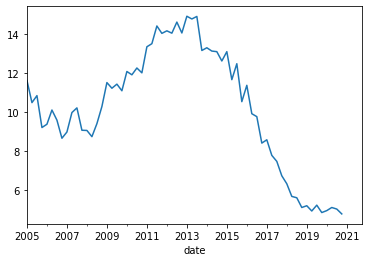

In [4]:
df['nplr'].plot()

# ADF test

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
passing_data=adfuller(df.nplr.dropna())

In [7]:
def adf_test(df):
    result=adfuller(df)
    labels = ['Test parameters', 'p-value','#Lags Used','Dataset observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Dataset is stationary")
    else:
        print("Dataset is non-stationary ")

In [8]:
adf_test(df.nplr.dropna()) #test cell

Test parameters : -3.354711992884267
p-value : 0.012603093473461544
#Lags Used : 11
Dataset observations : 52
Dataset is stationary


# KPSS test

In [9]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    if kpss_output[1] >= 0.05:
        print("Dataset have no trend")
    else:
        print("Dataset have trend ")

In [10]:
kpss_test(df.nplr.dropna())

Results of KPSS Test:
Test Statistic           0.462195
p-value                  0.050347
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Dataset have no trend


# Differencing if data not stationary in series or trend

In [11]:
df['Differencing_g']=df['nplr'].diff().diff()

<AxesSubplot:xlabel='date'>

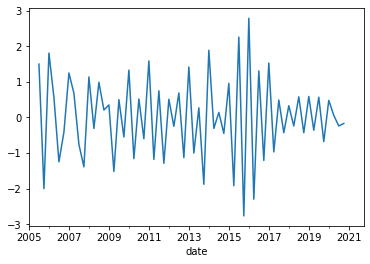

In [12]:
df['Differencing_g'].plot()

In [13]:
adf_test(df['Differencing_g'].dropna())

Test parameters : -5.91989711815662
p-value : 2.5209473223477e-07
#Lags Used : 4
Dataset observations : 57
Dataset is stationary


In [14]:
kpss_test(df['Differencing_g'].dropna())

Results of KPSS Test:
Test Statistic           0.061417
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Dataset have no trend


<AxesSubplot:xlabel='date'>

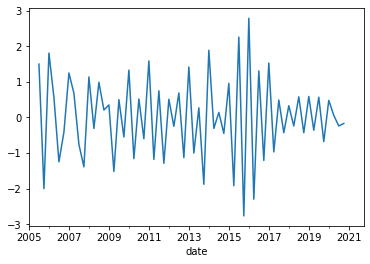

In [15]:
df['Differencing_g'].plot()

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# for q lags

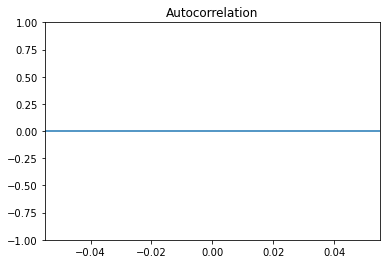

In [17]:
plot_acf(df.nplr) #5 lags
plt.show()

# for p lags

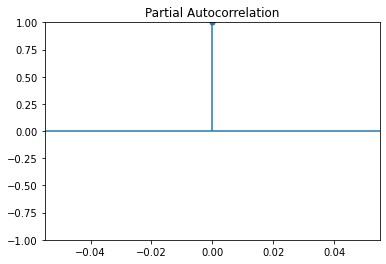

In [18]:
plot_pacf(df.nplr) #1 3 4 5 6
plt.show()

# auto sarima

In [19]:
model_1 = auto_arima(df.nplr.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5,  # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0,
                      start_Q=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      out_of_sample_size = 4,
                      scoring = 'mse',
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=133.916, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=196.492, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=140.886, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=135.664, Time=0.11 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=inf, Time=0.24 sec
 ARIMA(1,2,1)(0,0,1)[4]             : AIC=132.812, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[4]             : AIC=126.926, Time=0.44 sec
 ARIMA(1,2,1)(2,0,1)[4]             : AIC=inf, Time=0.61 sec
 ARIMA(1,2,1)(1,0,2)[4]             : AIC=inf, Time=0.64 sec
 ARIMA(1,2,1)(0,0,2)[4]             : AIC=131.943, Time=0.20 sec
 ARIMA(1,2,1)(2,0,0)[4]             : AIC=129.213, Time=0.22 sec
 ARIMA(1,2,1)(2,0,2)[4]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,1)(1,0,1)[4]             : AIC=127.331, Time=0.23 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=inf, Time=0.39 sec
 ARIMA(2,2,1)(1,0,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA

<AxesSubplot:xlabel='date'>

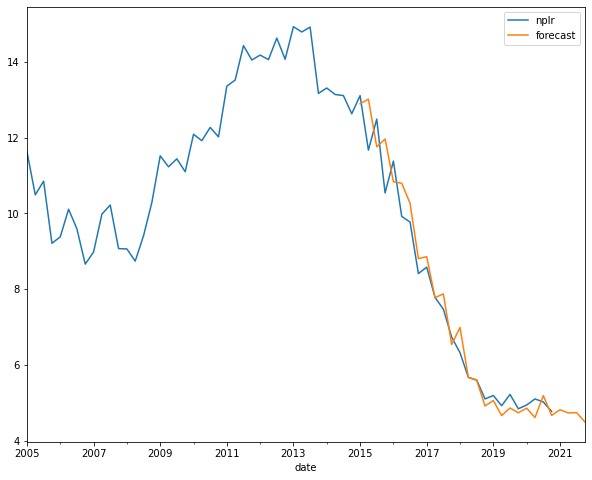

In [20]:
model=ARIMA(df.nplr.dropna(), order=(0, 1, 0),seasonal_order=(1,0,1,4))

sarima_model=model.fit()

df['forecast']=sarima_model.predict(start=40, end=67, dynamic=False)
df[['nplr','forecast']].plot(figsize=(10,8))

In [21]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              nplr   No. Observations:                   64
Model:             ARIMA(0, 1, 0)x(1, 0, [1], 4)   Log Likelihood                 -58.973
Date:                           Thu, 13 Apr 2023   AIC                            123.946
Time:                                   23:18:53   BIC                            130.375
Sample:                               03-01-2005   HQIC                           126.474
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.8122      0.138      5.876      0.000       0.541       1.083
ma.S.L4       -0.4346      0.245     -1.772      0.076      -0.915       0.046
sigma2         0.3708      0.058      6.430      0.000       0.258       0.484
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.74   Prob(JB):                         0.59
Heteroskedasticity (H):               0.41   Skew:                            -0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
df[['nplr', 'forecast']].tail(8)
#df.index

,nplr,forecast
date,,
2020-03-01,4.94,4.855445
2020-06-01,5.10,4.608252
2020-09-01,5.02,5.187416
2020-12-01,4.77,4.665160
2021-03-01,NaN,4.814469
2021-06-01,NaN,4.730706
2021-09-01,NaN,4.738490
2021-12-01,NaN,4.489890


# R-squared

In [23]:
from sklearn.metrics import r2_score
r2_score(df.nplr[50:63], df.forecast[50:63])

0.8499700208076831

In [24]:
'''
  The function calculates Root mean square error
  
  # The first parameter of function takes actual labels as actual
  # The second parameter of function takes predicted labels by the model 
    as predicted

  # The function returns calculated RMSE error of type float
'''
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [25]:
measure_rmse(df.nplr[-8:-4], df.forecast[-8:-4])

0.2683211131051731

## DW test (1.9-2.10)

In [26]:
sm.stats.durbin_watson(sarima_model.resid.values) # SARIMA Durbin test

1.3364944026656247